# ParameterizedLibrary Feature Overview
This notebook provides a simple overview of the ParameterizedLibrary functionality of PySINDy. Jupyter notebook written by Zachary Nicolaou.

In [37]:
#On the lambda-machine, limit the number of processors to vectorize over
import os
os.environ["OMP_NUM_THREADS"]="4"

import matplotlib.pyplot as plt
from pysindy.utils import lorenz
import pysindy as ps
import numpy as np
from scipy.integrate import solve_ivp
from pysindy.utils import lorenz
import timeit

In [38]:
#On the lambda-machine, limit the number of processors to vectorize over
import os
os.environ["OMP_NUM_THREADS"]="4"

import matplotlib.pyplot as plt
from pysindy.utils import lorenz
import pysindy as ps
import numpy as np
from scipy.integrate import solve_ivp
from pysindy.utils import lorenz
import timeit

In [2]:
# Initialize integrator keywords for solve_ivp to replicate the odeint defaults
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

### Fit a parameterized Lorenz model
The Lorenz equations
$$ \dot{x} = \sigma (y - x),$$
$$ \dot{y} = x(\rho - z) - y, $$
$$ \dot{z} = x y - \beta z. $$
depend on 3 parameters, $\sigma$, $\rho$, and $\beta$. We generate 10 trajectories with different parameter values.

In [28]:
start=timeit.default_timer()

dt = .002
num_trajectories=10
scalesigma=1
scalerho=1
scalebeta=1
sigmas=10 + scalesigma*(np.random.random(num_trajectories)-0.5)
rhos=28*np.ones(num_trajectories) + scalerho*(np.random.random(num_trajectories)-0.5)
betas=2.66667*np.ones(num_trajectories) + scalebeta*(np.random.random(num_trajectories)-0.5)
x_trains=[]
t_trains=[]
for i in range(len(sigmas)):
    t_train = np.arange(0, 10, dt)
    x0_train = [-8, 8, 27]
    t_train_span = (t_train[0], t_train[-1])
    x_train = solve_ivp(lorenz, t_train_span, x0_train, args=(sigmas[i],betas[i],rhos[i]),
                    t_eval=t_train, **integrator_keywords).y.T
    x_trains=x_trains+[x_train]
    t_trains=t_trains+[t_train]

stop=timeit.default_timer()
print(stop-start)

1.6397904031910002


Fitting any one trajectory gives the equation corresponding to a specfic set of parameter values. Can we discover the parameterized equations given all the trajectories?

In [31]:
lib=ps.PolynomialLibrary()
model = ps.SINDy(feature_library=lib,feature_names=['x', 'y', 'z', 'sigma', 'rho', 'beta'])
model.fit(x_trains[0], t=dt)
model.print()
print(lib.get_feature_names(['x', 'y', 'z', 'sigma', 'rho', 'beta']))

(x)' = -9.825 x + 9.825 y
(y)' = 27.783 x + -0.998 y + -1.000 x z
(z)' = -2.779 z + 1.000 x y
['1', 'x', 'y', 'z', 'x^2', 'x y', 'x z', 'y^2', 'y z', 'z^2']


We use the control input of ps.model to specify the parameter values, and fit a SINDy model with multiple trajectories.

Create list of control inputs corresponding to the parameters. The control inputs have the same shape as the data, but are constant across the temporal grid.

In [32]:
sigmas_timeseries=np.array(sigmas)[:,np.newaxis]*np.ones(t_trains[0].shape[0])[np.newaxis,:]
rhos_timeseries=np.array(rhos)[:,np.newaxis]*np.ones(t_trains[0].shape[0])[np.newaxis,:]
betas_timeseries=np.array(betas)[:,np.newaxis]*np.ones(t_trains[0].shape[0])[np.newaxis,:]
u_trains=[np.concatenate([np.transpose([sigmas_timeseries[i]]),np.transpose([rhos_timeseries[i]]),np.transpose([betas_timeseries[i]])],axis=1) for i in range(num_trajectories)]

Fitting a PolynomialLibrary with multiple_trajectories=True gives the correct model, but note that the same library functions are applied to the input features and the control input.

In [33]:
lib=ps.PolynomialLibrary()
model = ps.SINDy(feature_library=lib,feature_names=['x', 'y', 'z', 'sigma', 'rho', 'beta'])
model.fit(x_trains, u=u_trains, t=dt, multiple_trajectories=True)
model.print()
print(lib.get_feature_names(['x', 'y', 'z', 'sigma', 'rho', 'beta']))

(x)' = -1.000 x sigma + 1.000 y sigma
(y)' = -0.999 y + -1.000 x z + 1.000 x rho
(z)' = 1.000 x y + -1.000 z beta
['1', 'x', 'y', 'z', 'sigma', 'rho', 'beta', 'x^2', 'x y', 'x z', 'x sigma', 'x rho', 'x beta', 'y^2', 'y z', 'y sigma', 'y rho', 'y beta', 'z^2', 'z sigma', 'z rho', 'z beta', 'sigma^2', 'sigma rho', 'sigma beta', 'rho^2', 'rho beta', 'beta^2']


The ParameterizedLibrary enables different libraries to be applied to the control input and input features. In this case, the result is the same, but different libraries are required for the PDE case, since the derivatives of the parameters vanish.

In [34]:
feature_library=ps.PolynomialLibrary()
parameter_library=ps.PolynomialLibrary(degree=1)
lib=ps.ParameterizedLibrary(feature_library=feature_library,parameter_library=parameter_library, num_parameters=3)
model = ps.SINDy(feature_library=lib,feature_names=['x', 'y', 'z', 'sigma', 'rho', 'beta'])
model.fit(x_trains, u=u_trains, t=dt, multiple_trajectories=True)
model.print()
print(lib.get_feature_names(['x', 'y', 'z', 'sigma', 'rho', 'beta']))

(x)' = -1.000 sigma x + 1.000 sigma y
(y)' = -0.999 1 y + -1.000 1 x z + 1.000 rho x
(z)' = 1.000 1 x y + -1.000 beta z
['1 1', '1 x', '1 y', '1 z', '1 x^2', '1 x y', '1 x z', '1 y^2', '1 y z', '1 z^2', 'sigma 1', 'sigma x', 'sigma y', 'sigma z', 'sigma x^2', 'sigma x y', 'sigma x z', 'sigma y^2', 'sigma y z', 'sigma z^2', 'rho 1', 'rho x', 'rho y', 'rho z', 'rho x^2', 'rho x y', 'rho x z', 'rho y^2', 'rho y z', 'rho z^2', 'beta 1', 'beta x', 'beta y', 'beta z', 'beta x^2', 'beta x y', 'beta x z', 'beta y^2', 'beta y z', 'beta z^2']


### Fit a parameterized complex Ginzburg-Landau equation
The complex Ginzburg-Landau equation
$$ \dot{A} = A + (1+ib)\nabla^2 A - (1-ic)|A|^2A$$
describes the evolution of the mode amplitude $A$ for pattern formation in a long-wavelength, supercritical Hopf bifurcation. It depends on two parameters $b$ and $c$. We generate 4 trajectories with different values of the parameters. (Note: this will take 5 minutes)

In [130]:
nx=128
ny=128
L=16
t1=1e2
t3=8e1
dt=1e-1
def cgle(t, Z, b, c):
    Zxxr=ps.SpectralDerivative(d=2,axis=0)._differentiate(np.real(Z).reshape((nx,ny)),1.0/nx)
    Zyyr=ps.SpectralDerivative(d=2,axis=1)._differentiate(np.real(Z).reshape((nx,ny)),1.0/ny)
    Zxxi=ps.SpectralDerivative(d=2,axis=0)._differentiate(np.imag(Z).reshape((nx,ny)),1.0/nx)
    Zyyi=ps.SpectralDerivative(d=2,axis=1)._differentiate(np.imag(Z).reshape((nx,ny)),1.0/ny)
    lap=(Zxxr+1j*Zxxi+Zyyr+1j*Zyyi).reshape(N)    
    return Z - (1-1j*c)*Z*Z*Z.conjugate() + (1+1j*b)*lap/(2*np.pi*L)**2


spatial_grid=np.zeros((nx,ny,2))
spatial_grid[:,:,0]=(np.arange(nx)-nx//2)[:,np.newaxis]*2*np.pi*L/nx
spatial_grid[:,:,1]=(np.arange(nx)-nx//2)[np.newaxis,:]*2*np.pi*L/nx

nt=int(t1/dt)-int(t3/dt)
bs=[-2.0, 1.0]
cs=[0.5, 1.8]

xs=[]
for b in bs:
    for c in cs:
        start=timeit.default_timer()
        k=5
        scale=0.5
        phase_init = np.exp(1j*(2*np.pi * np.random.random(N)))
#         phase_init=np.zeros((nx,ny),dtype=np.complex128)
#         phase_init[:]=(np.exp(1j*k*2*np.pi*np.arange(nx)/nx)[:,np.newaxis])+scale*np.exp(1j*(2*np.pi * np.random.random((nx,ny))))
        phases=np.zeros( [int(t1/dt), N], dtype=np.complex128 )
        phase=phase_init.reshape(N)
        times=[]
        dt1=dt/1000
        for n in range(int(t1/dt)):
            t=n*dt
            print('%.1f'%(t),end='\r')
            sol=solve_ivp(cgle, [t,t+dt], phase, method='RK45', args=(b, c), rtol=1e-6, atol=1e-6, first_step=dt1)
            times.append(sol.t)
            dt1=np.mean(np.diff(sol.t))
            phase=sol.y[:,-1]
            phases[n] = phase

        stop=timeit.default_timer()
        print(stop-start)
        x=np.zeros((nx,ny,nt,2))
        x[:,:,:,0]=np.real(phases.reshape((int(t1/dt),nx,ny))[int(t3/dt):].transpose((1,2,0)))
        x[:,:,:,1]=np.imag(phases.reshape((int(t1/dt),nx,ny))[int(t3/dt):].transpose((1,2,0)))
        xs.append(x)

73.36567461909726
74.76073270011693
50.84500296926126
52.386462030000985


Depending on the parameter values, the system exhibits different dynamical phases.

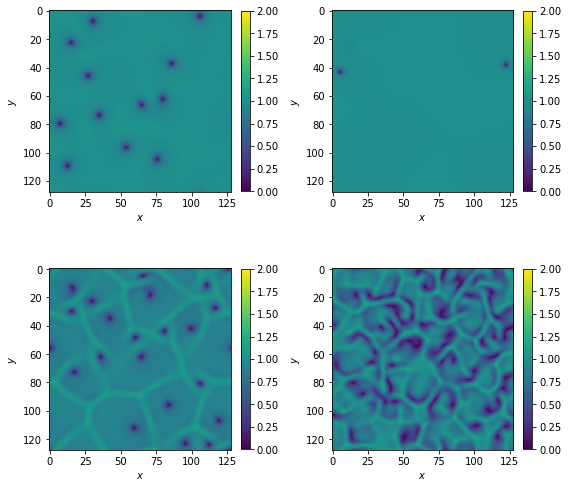

In [131]:
nt=-2
plt.subplots(2,2,figsize=(8,8))
for i in range(len(xs)):
    plt.subplot(2,2,i+1)
    plt.imshow(np.arctan(xs[i][:,:,-1,0],xs[i][:,:,-1,1]), vmin=0, vmax=2)
#     plt.imshow(np.sqrt(xs[i][:,:,nt,0]**2+xs[i][:,:,nt,1]**2), vmin=0, vmax=2)
    plt.colorbar(fraction=0.045)
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.tight_layout()
plt.show()

Fitting any one trajectory gives the equation corresponding to a specfic set of parameter values. Can we discover the parameterized equations given all the trajectories?

In [132]:
start=timeit.default_timer()
lib=ps.PDELibrary(library_functions=[lambda x:x, lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x],derivative_order=2,spatial_grid=spatial_grid,include_interaction=False,function_names=[lambda x:x, lambda x:x+x+x, lambda x,y:x+x+y,  lambda x,y:x+y+y],periodic=True)
opt=ps.STLSQ(threshold=1e-1,alpha=1e-3,normalize_columns=False)
model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y'])
model.fit(xs[0],t=dt)
model.print()
stop=timeit.default_timer()
print(stop-start)

(x)' = 0.973 x + -0.973 xxx + -0.500 yyy + -0.500 xxy + -0.973 xyy + 0.972 x_22 + 1.999 y_22 + 0.973 x_11 + 2.000 y_11
(y)' = 0.973 y + 0.500 xxx + -0.973 yyy + -0.973 xxy + 0.500 xyy + -1.999 x_22 + 0.972 y_22 + -2.001 x_11 + 0.974 y_11
12.497851870954037


Create list of control inputs corresponding to the parameters. The control inputs have the same shape as the data, but are constant across the spatiotemporal grid.

In [135]:
us=[]
for b in bs:
    for c in cs:
        u=np.zeros(np.concatenate([xs[0].shape[:-1],[2]]))
        u[:,:,:,0]=b
        u[:,:,:,1]=c
        us.append(u)

Try a SINDy model with multiple trajectories using the PDELibrary applied to both the input features xs and the control features us. Note that the spatial derivatives of the control features vanish, so the fit will be poorly conditions

In [145]:
#Note: permutations of the variable combinations are not currently included!

In [146]:
start=timeit.default_timer()
library_functions=[lambda x:x, lambda x:x**3, lambda x,y:x**2*y, lambda x,y:y**2*x, lambda x,y,z: x*y*z**2,lambda x,y,z: x*y**2*z,lambda x,y,z: x**2*y*z]
function_names=[lambda x:x, lambda x:x+x+x, lambda x,y:x+x+y,lambda x,y:x+y+y,lambda x,y,z:x+y+z+z,lambda x,y,z:x+y+y+z,lambda x,y,z:x+x+y+z]
lib=ps.PDELibrary(library_functions=library_functions,derivative_order=2,spatial_grid=spatial_grid,include_interaction=False,function_names=function_names,periodic=True)
opt=ps.STLSQ(threshold=1e-1,alpha=1e-3,normalize_columns=False)
model = ps.SINDy(feature_library=lib,optimizer=opt,feature_names=['x', 'y', 'b', 'c'])
model.fit(xs,u=us,t=dt,multiple_trajectories=True)
model.print()
stop=timeit.default_timer()
print(stop-start)
print(lib.get_feature_names(['x', 'y', 'b', 'c']))

(x)' = 0.795 x + 0.504 y + -0.793 xxx + -0.978 yyy + -0.977 xxy + -0.794 xyy + -0.435 ycc + 0.819 x_22 + -0.954 y_22 + 0.819 x_11 + -0.937 y_11
(y)' = -0.503 x + 0.796 y + 0.975 xxx + -0.795 yyy + -0.794 xxy + 0.976 xyy + 0.435 xcc + 0.954 x_22 + 0.817 y_22 + 0.942 x_11 + 0.822 y_11
141.6750384271145
['x', 'y', 'b', 'c', 'xxx', 'yyy', 'bbb', 'ccc', 'xxy', 'xxb', 'xxc', 'yyb', 'yyc', 'bbc', 'xyy', 'xbb', 'xcc', 'ybb', 'ycc', 'bcc', 'xybb', 'xycc', 'xbcc', 'ybcc', 'xyyb', 'xyyc', 'xbbc', 'ybbc', 'xxyb', 'xxyc', 'xxbc', 'yybc', 'x_2', 'y_2', 'b_2', 'c_2', 'x_22', 'y_22', 'b_22', 'c_22', 'x_1', 'y_1', 'b_1', 'c_1', 'x_12', 'y_12', 'b_12', 'c_12', 'x_11', 'y_11', 'b_11', 'c_11']


TODO: Try a SINDy model with multiple trajectories using the ParameterizedLibrary. Use a PDELibrary for the feature_library with second-order derivatives and library functions that include the relevant cubic term. Use a PDELibrary for the parameter_library with zeroth-order derivatives and linear library functions. 

(Note: we could try to use a PolynomialLibrary for the parameter_library, but note that the shape of the control features is expected to be 2-dimensional for the PolynomialLibrary, whereas the PDELibrary automatically flattens the spatiotemporal axes to produce the transformed matrix.) 